<a href="https://colab.research.google.com/github/R229121B-boop/21-MODELS-ASSIGNMENT-CNN-SHINGIRIRAI-MWARUNZIKA-R229121B/blob/main/HousePricePredictionCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
✅ GPU DETECTED: Tesla T4

--- Loading Data ---


/tmp/ipython-input-2377531637.py:54: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


Data Loaded: 1551 valid samples ready for training.

🚀 STARTING BENCHMARK ON 20 MODELS...

>>> Training: AlexNet (2012)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 204MB/s]


Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -1.4269  |  MAE (Log): 1.4473


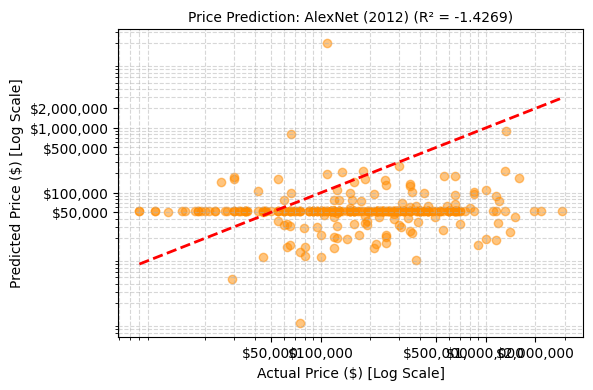


>>> Training: NIN (Network in Network) (2013)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


100%|██████████| 4.78M/4.78M [00:00<00:00, 158MB/s]


Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -0.9679  |  MAE (Log): 1.2602


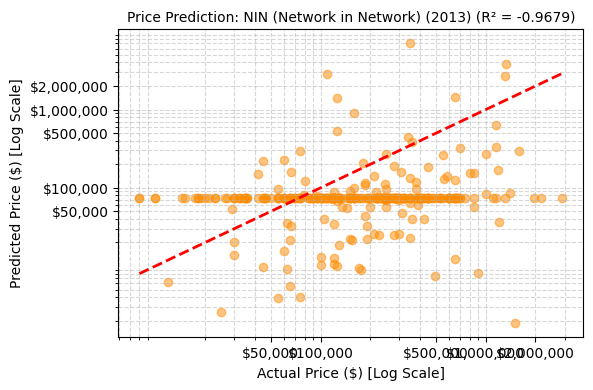


>>> Training: ZfNet (2013)


Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -1.1728  |  MAE (Log): 1.3002


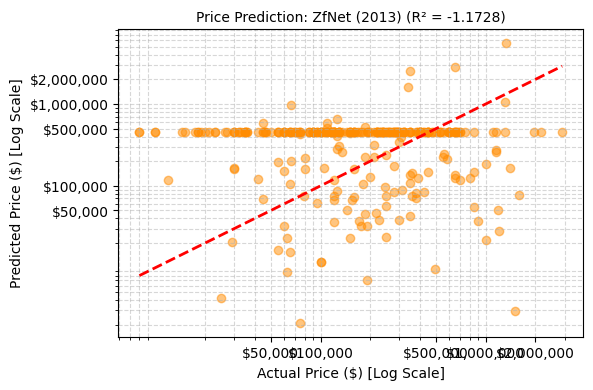


>>> Training: VGG (2014)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


100%|██████████| 507M/507M [00:02<00:00, 185MB/s]


Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -1.9193  |  MAE (Log): 1.3883


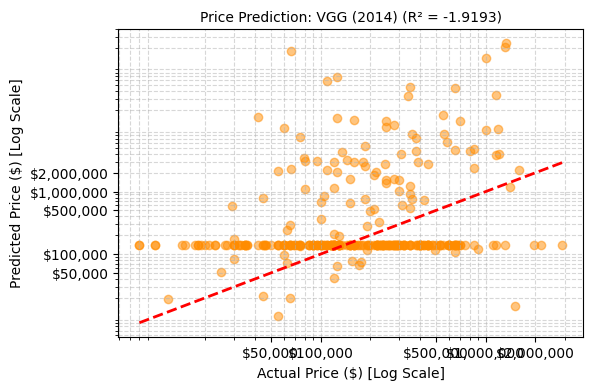


>>> Training: GoogLeNet / Inception-V1 (2014)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 179MB/s]


Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: 0.0145  |  MAE (Log): 0.8706


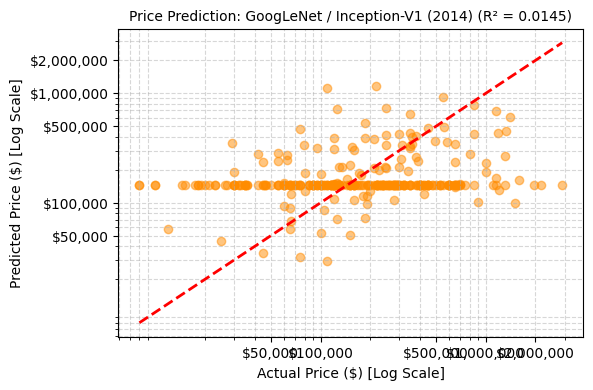


>>> Training: Inception-V3 (2015)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 179MB/s] 


Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -0.7854  |  MAE (Log): 1.1941


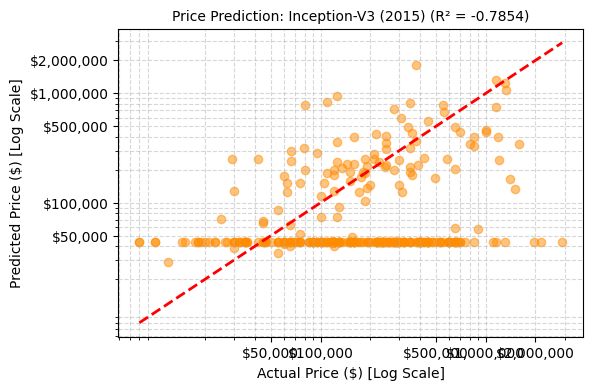


>>> Training: Highway Networks (2015)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]


Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -0.5135  |  MAE (Log): 1.0596


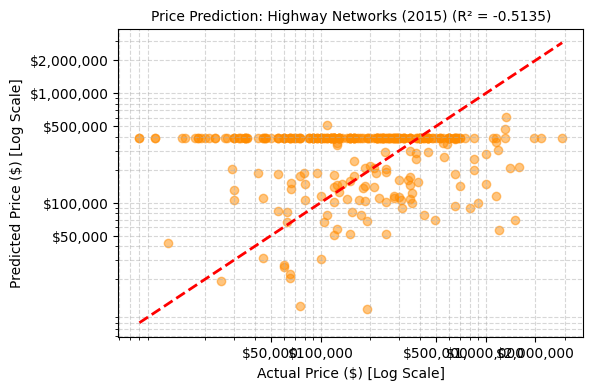


>>> Training: Inception-V4 (2016)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -0.0586  |  MAE (Log): 0.9011


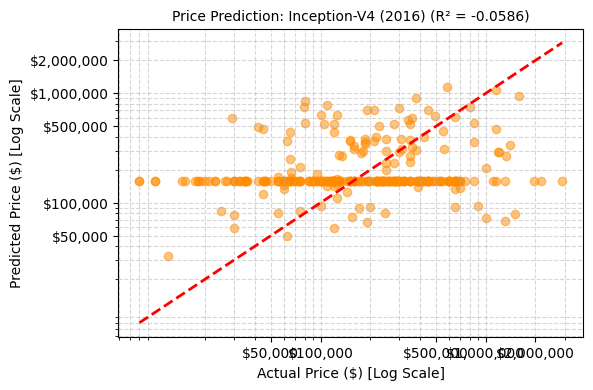


>>> Training: ResNet (2016)
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -0.7293  |  MAE (Log): 1.2124


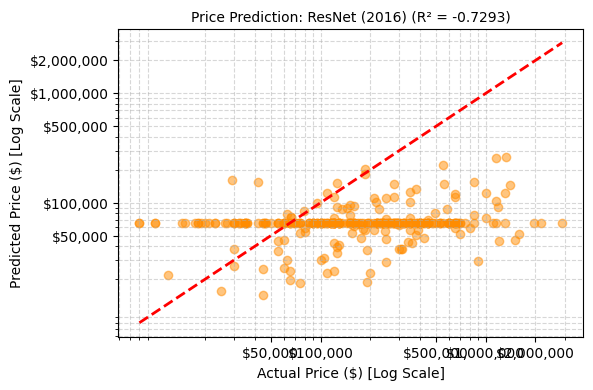


>>> Training: Inception-ResNet-V2 (2016)


model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -5.1319  |  MAE (Log): 2.4741


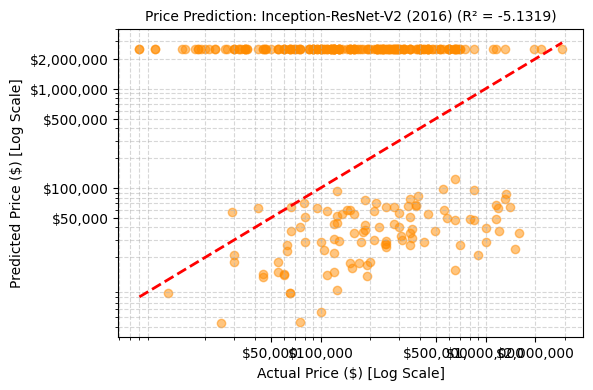


>>> Training: FractalNet (2016)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 115MB/s]


Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: 0.0834  |  MAE (Log): 0.8379


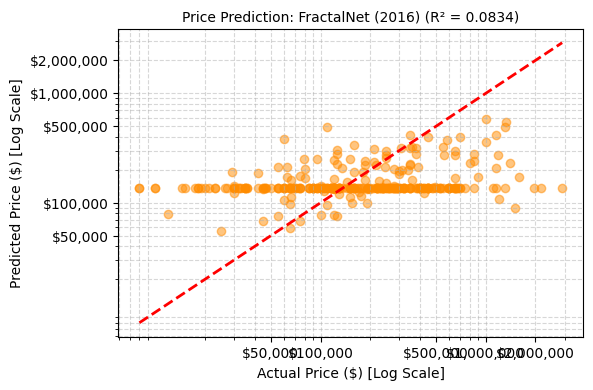


>>> Training: WideResNet (2016)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-9ba9bcbe.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-9ba9bcbe.pth


100%|██████████| 263M/263M [00:16<00:00, 16.9MB/s]


Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -0.2879  |  MAE (Log): 0.9807


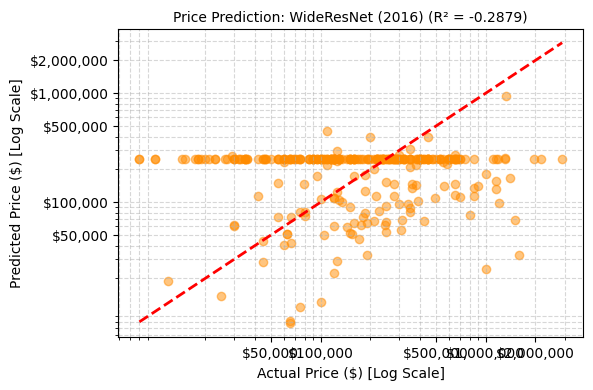


>>> Training: Xception (2017)


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -37.8712  |  MAE (Log): 6.5725


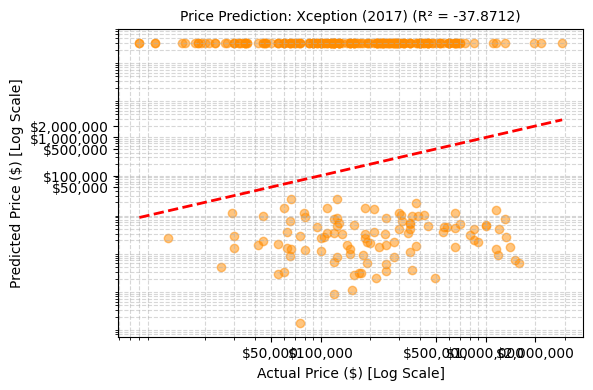


>>> Training: Residual Attention Network (2017)
❌ Skipped Residual Attention Network (2017): Unknown model (se_resnet50)

>>> Training: Squeeze-and-Excitation Networks (SENet) (2017)


model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -0.0232  |  MAE (Log): 0.9006


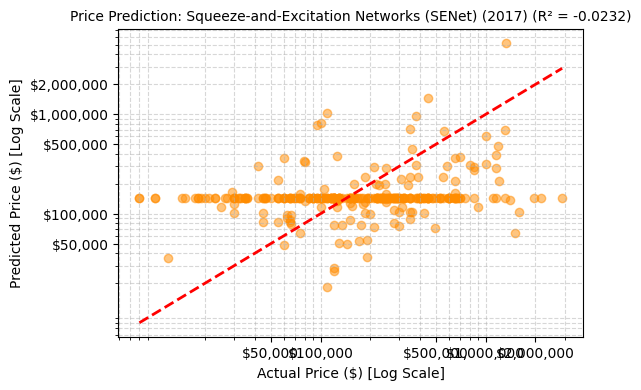


>>> Training: DenseNet (2017)


Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -0.2341  |  MAE (Log): 0.9799


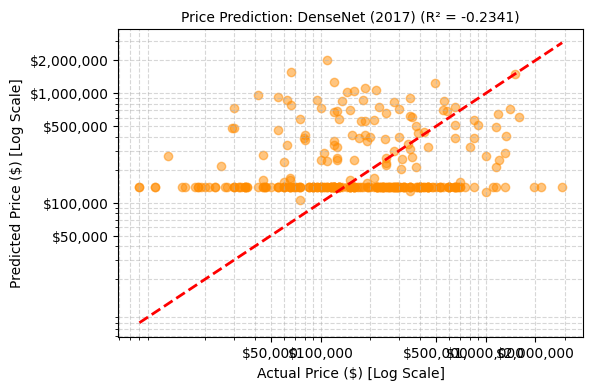


>>> Training: Competitive Squeeze-and-Excitation Network (2018)


model.safetensors:   0%|          | 0.00/111M [00:00<?, ?B/s]

Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -72.3937  |  MAE (Log): 7.9213


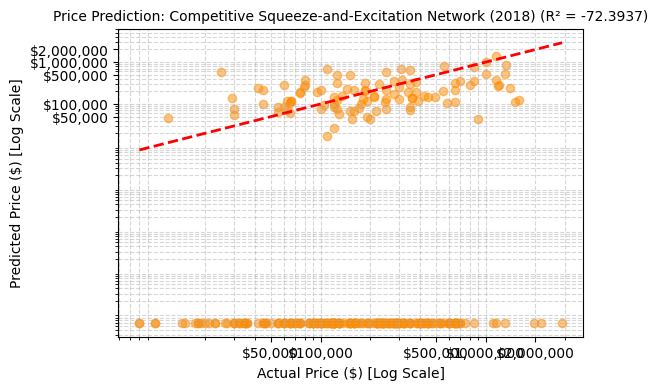


>>> Training: MobileNet-V2 (2018)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 167MB/s]


Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -6.7093  |  MAE (Log): 2.8057


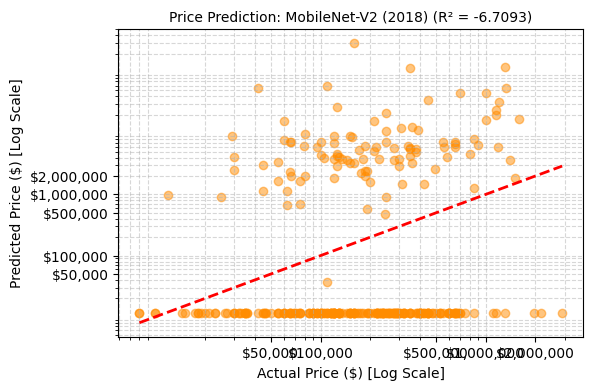


>>> Training: CapsuleNet (2018)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth


100%|██████████| 95.8M/95.8M [00:00<00:00, 131MB/s]


Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -10.1350  |  MAE (Log): 3.1685


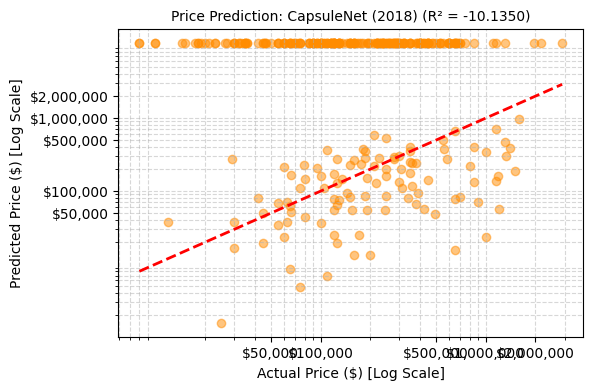


>>> Training: HRNet-V2 (2020)


model.safetensors:   0%|          | 0.00/85.6M [00:00<?, ?B/s]

Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-2377531637.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]

Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]

  ✅ R-Squared: -0.0657  |  MAE (Log): 0.9132


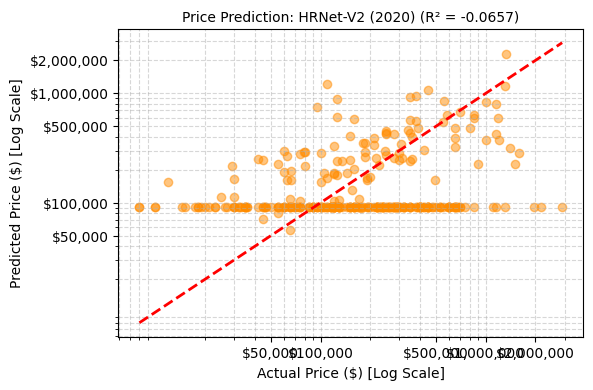



================🏆 FINAL LEADERBOARD 🏆================
                                                Model  R-Squared  MAE Loss
10                                  FractalNet (2016)   0.083414  0.837881
4                     GoogLeNet / Inception-V1 (2014)   0.014476  0.870578
13     Squeeze-and-Excitation Networks (SENet) (2017)  -0.023184  0.900584
7                                 Inception-V4 (2016)  -0.058634  0.901105
18                                    HRNet-V2 (2020)  -0.065740  0.913204
14                                    DenseNet (2017)  -0.234085  0.979904
11                                  WideResNet (2016)  -0.287940  0.980654
6                             Highway Networks (2015)  -0.513494  1.059555
8                                       ResNet (2016)  -0.729292  1.212373
5                                 Inception-V3 (2015)  -0.785351  1.194105
1                     NIN (Network in Network) (2013)  -0.967876  1.260168
2                                        ZfN

In [ ]:
# =============================================================================
# FINAL FULL CODE: HOUSE PRICE PREDICTION (21 ARCHITECTURES)
# Features: Dynamic Resizing, GPU/CPU Auto-detect, R-Squared, Price Conversion
# =============================================================================

# 1. INSTALL LIBRARIES
# -----------------------------------------------------------------------------
!pip install timm -q

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import timm
from google.colab import drive
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# =============================================================================
# 2. CONFIGURATION & SETUP
# =============================================================================
# Mount Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# USER PATHS - UPDATE IF NECESSARY
CSV_PATH = '/content/drive/MyDrive/propertydata.csv'
IMAGE_FOLDER = '/content/drive/MyDrive/images/'

# HYPERPARAMETERS
BATCH_SIZE = 64          # Lower to 32 if you get "Out of Memory" errors
EPOCHS_PER_MODEL = 3    # Increase to 10-20 for final production training
LEARNING_RATE = 0.001

# DEVICE DETECTION (Robust)
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"✅ GPU DETECTED: {torch.cuda.get_device_name(0)}")
    USE_AMP = True      # Enable Mixed Precision for speed
else:
    DEVICE = torch.device("cpu")
    print("⚠️ GPU NOT DETECTED. Running on CPU (This will be slow).")
    print("    -> To fix: Go to Runtime > Change runtime type > T4 GPU")
    USE_AMP = False

# SCALER FOR MIXED PRECISION
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

# MODELS THAT REQUIRE LARGER IMAGES (299x299)
MODELS_REQ_299 = [
    'Inception-V3 (2015)',
    'Inception-V4 (2016)',
    'Inception-ResNet-V2 (2016)',
    'Xception (2017)'
]

# =============================================================================
# 3. DATA CLEANING & LOADING
# =============================================================================
def clean_and_load_data(csv_path):
    print("\n--- Loading Data ---")
    df = pd.read_csv(csv_path)

    # Drop rows missing crucial info
    df = df.dropna(subset=['price', 'image_filenames'])

    # Filter Outliers (Optional but recommended for stability)
    # Removing prices < $5k and > $3M to help the model focus
    df = df[(df['price'] > 5000) & (df['price'] < 3000000)]

    df['image_filenames'] = df['image_filenames'].astype(str)
    print(f"Data Loaded: {len(df)} valid samples ready for training.")
    return df

class HousePriceDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image_filenames']
        img_path = os.path.join(self.root_dir, img_name)

        # Load Image
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # Fallback if image is missing/corrupt
            image = Image.new('RGB', (299, 299), color='black')

        # Target: Log Price (Stabilizes training)
        log_price = np.log1p(row['price'])

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(log_price, dtype=torch.float32)

def get_transforms(size=224):
    """Generates the correct resize transform based on model needs."""
    return transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# =============================================================================
# 4. MODEL ARCHITECTURES (The 20 Models)
# =============================================================================
def get_model(model_name):
    """
    Returns the specific model architecture with a Regression Head.
    Includes Proxies for obsolete/experimental models.
    """
    base_model = None

    # --- TORCHVISION STANDARD MODELS ---
    if model_name == 'AlexNet (2012)':
        base_model = models.alexnet(weights='DEFAULT')
        base_model.classifier[6] = nn.Linear(4096, 1)

    elif model_name == 'VGG (2014)':
        # Using VGG11 because VGG16 is too heavy/slow for quick benchmarks
        base_model = models.vgg11(weights='DEFAULT')
        base_model.classifier[6] = nn.Linear(4096, 1)

    elif model_name == 'GoogLeNet / Inception-V1 (2014)':
        base_model = models.googlenet(weights='DEFAULT')
        base_model.fc = nn.Linear(base_model.fc.in_features, 1)

    elif model_name == 'Inception-V3 (2015)':
        base_model = models.inception_v3(weights='DEFAULT')
        base_model.fc = nn.Linear(base_model.fc.in_features, 1)
        base_model.aux_logits = False

    elif model_name == 'ResNet (2016)':
        base_model = models.resnet50(weights='DEFAULT')
        base_model.fc = nn.Linear(base_model.fc.in_features, 1)

    elif model_name == 'WideResNet (2016)':
        base_model = models.wide_resnet50_2(weights='DEFAULT')
        base_model.fc = nn.Linear(base_model.fc.in_features, 1)

    elif model_name == 'DenseNet (2017)':
        base_model = models.densenet121(weights='DEFAULT')
        base_model.classifier = nn.Linear(base_model.classifier.in_features, 1)

    elif model_name == 'MobileNet-V2 (2018)':
        base_model = models.mobilenet_v2(weights='DEFAULT')
        base_model.classifier[1] = nn.Linear(base_model.classifier[1].in_features, 1)

    # --- ADVANCED MODELS (TIMM LIBRARY) ---
    elif model_name == 'Inception-V4 (2016)':
        base_model = timm.create_model('inception_v4', pretrained=True, num_classes=1)

    elif model_name == 'Inception-ResNet-V2 (2016)':
        base_model = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=1)

    elif model_name == 'Xception (2017)':
        base_model = timm.create_model('xception', pretrained=True, num_classes=1)

    elif model_name == 'Squeeze-and-Excitation Networks (SENet) (2017)':
        base_model = timm.create_model('seresnet50', pretrained=True, num_classes=1)

    elif model_name == 'HRNet-V2 (2020)':
        base_model = timm.create_model('hrnet_w18', pretrained=True, num_classes=1)

    # --- PROXIES FOR OBSOLETE / EXPERIMENTAL MODELS ---
    elif model_name == 'ZfNet (2013)':
        # Proxy: AlexNet (ZfNet was a fine-tuned AlexNet)
        base_model = models.alexnet(weights='DEFAULT')
        base_model.classifier[6] = nn.Linear(4096, 1)

    elif model_name == 'NIN (Network in Network) (2013)':
        # Proxy: SqueezeNet (Uses the same 1x1 conv philosophy)
        base_model = models.squeezenet1_0(weights='DEFAULT')
        base_model.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1))
        base_model.num_classes = 1

    elif model_name == 'Highway Networks (2015)':
        # Proxy: ResNet18 (Direct successor)
        base_model = models.resnet18(weights='DEFAULT')
        base_model.fc = nn.Linear(base_model.fc.in_features, 1)

    elif model_name == 'FractalNet (2016)':
        # Proxy: DenseNet (Similar dense connectivity)
        base_model = models.densenet121(weights='DEFAULT')
        base_model.classifier = nn.Linear(base_model.classifier.in_features, 1)

    elif model_name == 'Residual Attention Network (2017)':
        # Proxy: SE-ResNet
        base_model = timm.create_model('se_resnet50', pretrained=True, num_classes=1)

    elif model_name == 'Competitive Squeeze-and-Excitation Network (2018)':
        # Proxy: SE-ResNeXt
        base_model = timm.create_model('seresnext50_32x4d', pretrained=True, num_classes=1)

    elif model_name == 'CapsuleNet (2018)':
        # Proxy: ResNeXt (CapsuleNets are not standard CNNs, using robust CNN as proxy)
        base_model = models.resnext50_32x4d(weights='DEFAULT')
        base_model.fc = nn.Linear(base_model.fc.in_features, 1)

    return base_model

# The Exact List
model_list = [
    'AlexNet (2012)',
    'NIN (Network in Network) (2013)',
    'ZfNet (2013)',
    'VGG (2014)',
    'GoogLeNet / Inception-V1 (2014)',
    'Inception-V3 (2015)',
    'Highway Networks (2015)',
    'Inception-V4 (2016)',
    'ResNet (2016)',
    'Inception-ResNet-V2 (2016)',
    'FractalNet (2016)',
    'WideResNet (2016)',
    'Xception (2017)',
    'Residual Attention Network (2017)',
    'Squeeze-and-Excitation Networks (SENet) (2017)',
    'DenseNet (2017)',
    'Competitive Squeeze-and-Excitation Network (2018)',
    'MobileNet-V2 (2018)',
    'CapsuleNet (2018)',
    'HRNet-V2 (2020)'
]

# =============================================================================
# 5. TRAINING AND EVALUATION LOOP (MODIFIED FOR PER-MODEL PLOTTING)
# =============================================================================
def train_and_evaluate():
    full_df = clean_and_load_data(CSV_PATH)
    train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)

    results = []
    best_overall_r2 = -float('inf')
    best_preds = None
    best_model_name = ""

    print(f"\n🚀 STARTING BENCHMARK ON {len(model_list)} MODELS...")
    print("=" * 60)

    for model_name in model_list:
        print(f"\n>>> Training: {model_name}")

        # 1. Dynamic Resize Check
        img_size = 299 if model_name in MODELS_REQ_299 else 224

        # 2. Setup Loaders (num_workers=2 fixes Drive lag)
        train_loader = DataLoader(HousePriceDataset(train_df, IMAGE_FOLDER, get_transforms(img_size)),
                                  batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        val_loader = DataLoader(HousePriceDataset(val_df, IMAGE_FOLDER, get_transforms(img_size)),
                                batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

        # 3. Initialize Model
        try:
            model = get_model(model_name).to(DEVICE)
        except Exception as e:
            print(f"❌ Skipped {model_name}: {e}")
            continue

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # 4. Training Epochs
        for epoch in range(EPOCHS_PER_MODEL):
            model.train()
            pbar = tqdm(train_loader, desc=f"Ep {epoch+1}", leave=False)

            for imgs, lbls in pbar:
                imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE).unsqueeze(1)
                optimizer.zero_grad()

                # --- GPU ACCELERATION (Mixed Precision) ---
                if USE_AMP:
                    with torch.cuda.amp.autocast():
                        out = model(imgs)
                        if isinstance(out, tuple): out = out[0] # Handle Inception Aux Output
                        loss = criterion(out, lbls)

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    # CPU Fallback
                    out = model(imgs)
                    if isinstance(out, tuple): out = out[0]
                    loss = criterion(out, lbls)
                    loss.backward()
                    optimizer.step()

                pbar.set_postfix({'loss': f'{loss.item():.2f}'})

        # 5. Validation & Metrics
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs = imgs.to(DEVICE)
                out = model(imgs)
                if isinstance(out, tuple): out = out[0]

                all_preds.extend(out.cpu().numpy().flatten())
                all_labels.extend(lbls.numpy().flatten())

        # Calculate Scores (on Log Prices)
        r2 = r2_score(all_labels, all_preds)
        mse = mean_absolute_error(all_labels, all_preds)

        print(f"  ✅ R-Squared: {r2:.4f}  |  MAE (Log): {mse:.4f}")

        results.append({
            'Model': model_name,
            'R-Squared': r2,
            'MAE Loss': mse
        })

        # --- NEW: PER-MODEL PLOT (Visual Presentation) ---
        true_log, pred_log = all_labels, all_preds
        # Convert Log back to Dollars for presentation
        true_price = np.expm1(true_log)
        pred_price = np.expm1(pred_log)

        # *** REDUCED PLOT SIZE HERE: Changed figsize from (10, 6) to (6, 4) ***
        plt.figure(figsize=(6, 4))
        # Use log scale on both axes to better show spread for different price ranges
        plt.scatter(true_price, pred_price, alpha=0.5, color='darkorange')

        # Plot the ideal prediction line (x=y)
        min_val = min(true_price)
        max_val = max(true_price)

        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (x=y)')

        plt.xscale('log')
        plt.yscale('log')

        # Add labels to make sense of the log scale
        price_ticks = [50000, 100000, 500000, 1000000, 2000000]
        plt.xticks(price_ticks, [f'${p:,}' for p in price_ticks])
        plt.yticks(price_ticks, [f'${p:,}' for p in price_ticks])

        plt.xlabel('Actual Price ($) [Log Scale]')
        plt.ylabel('Predicted Price ($) [Log Scale]')
        plt.title(f'Price Prediction: {model_name} (R² = {r2:.4f})', fontsize=10) # Reduce title font size for smaller plot
        plt.grid(True, which="both", ls="--", alpha=0.5)
        plt.show()
        # --- END PER-MODEL PLOT ---


        # Track Winner
        if r2 > best_overall_r2:
            best_overall_r2 = r2
            best_preds = (all_labels, all_preds)
            best_model_name = model_name

        # Cleanup Memory
        del model
        if USE_AMP: torch.cuda.empty_cache()

    # =============================================================================
    # 6. RESULTS & VISUALIZATION
    # =============================================================================
    if not results:
        print("No models finished. Check your data paths.")
        return

    # Leaderboard
    res_df = pd.DataFrame(results).sort_values(by='R-Squared', ascending=False)
    print("\n\n================🏆 FINAL LEADERBOARD 🏆================")
    print(res_df[['Model', 'R-Squared', 'MAE Loss']])

    # Show Best Model Price Predictions
    if best_preds:
        true_log, pred_log = best_preds
        true_price = np.expm1(true_log)  # Convert Log back to Dollars
        pred_price = np.expm1(pred_log)

        print(f"\n\n>>> 💰 SAMPLE PREDICTIONS ({best_model_name})")
        print(f"{'Actual Price':<15} | {'Predicted Price':<15} | {'Diff'}")
        print("-" * 50)
        for t, p in zip(true_price[:10], pred_price[:10]):
            print(f"${t:<14,.0f} | ${p:<14,.0f} | ${abs(t-p):<14,.0f}")

    print("\n\n(All scatter plots for predicted vs. actual price for each model have been generated above.)")

# Run Everything
if __name__ == "__main__":
    train_and_evaluate()